# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.chdir('/Users/soumyadeepray/My Documents/DS_Projects/BCG_Virtual_Internship/data')

---
## 2. Load data

In [3]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [4]:
df.head(5)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_year_price_off_peak_var,mean_year_price_peak_var,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_med_peak_y,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0


---

## 3. Feature engineering

#### Difference between off-peak prices in December and preceding January

In [5]:
price_df = pd.read_csv('./price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [7]:
df = pd.merge(df, diff, on='id')
df.head(5)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_year_price_mid_peak_var,mean_year_price_off_peak_fix,mean_year_price_peak_fix,mean_year_price_mid_peak_fix,mean_year_price_off_peak,mean_year_price_peak,mean_year_price_med_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1,0.020057,3.700961
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0,-0.003767,0.177779
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0,-0.004670,0.177779
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0,-0.004547,0.177779
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0,-0.006192,0.162916


#### Aggregate average prices per company


In [8]:
mean_prices = price_df.groupby(['id']).agg({'price_off_peak_var':'mean', 
                                           'price_peak_var':'mean',
                                           'price_mid_peak_var':'mean',
                                           'price_off_peak_fix':'mean', 
                                           'price_peak_fix':'mean',
                                           'price_mid_peak_fix':'mean'}
                                           ).reset_index()

#### Calculate the mean difference between consecutive periods (price_off_peak -> price_peak -> price_mid_peak)


In [9]:
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694,0.020545,0.030633,0.051178,16.280694,8.140345,24.421038
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000,0.146426,0.000000,0.146426,44.385450,0.000000,44.385450
2,0010bcc39e42b3c2131ed2ce55246e3c,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000,0.181558,0.000000,0.181558,45.319710,0.000000,45.319710
3,0010ee3855fdea87602a5b7aba8e42de,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971,0.020465,0.029260,0.049725,16.258972,8.129484,24.388456
4,00114d74e963e47177db89bc70108537,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000,0.147926,0.000000,0.147926,44.266930,0.000000,44.266930
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.138863,0.115125,0.080780,40.896427,24.637456,16.507972,0.023739,0.034344,0.058083,16.258971,8.129484,24.388455
16092,fffac626da707b1b5ab11e8431a4d0a2,0.147137,0.000000,0.000000,44.311375,0.000000,0.000000,0.147137,0.000000,0.147137,44.311375,0.000000,44.311375
16093,fffc0cacd305dd51f316424bbb08d1bd,0.153879,0.129497,0.094842,41.160171,24.895768,16.763569,0.024382,0.034655,0.059037,16.264402,8.132199,24.396601
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.123858,0.103499,0.073735,40.606699,24.364017,16.242678,0.020359,0.029764,0.050123,16.242682,8.121339,24.364021


In [10]:
columns = ['id', 
           'off_peak_peak_var_mean_diff', 
           'peak_mid_peak_var_mean_diff',
           'off_peak_mid_peak_var_mean_diff', 
           'off_peak_peak_fix_mean_diff',
           'peak_mid_peak_fix_mean_diff', 
           'off_peak_mid_peak_fix_mean_diff']
df = pd.merge(df, mean_prices[columns], on='id')
df.head(5)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_year_price_med_peak_y,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,8.182687,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,16.365274,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


#### Aggregate average prices per period per company


In [11]:
mean_prices_per_month = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var':'mean', 
                                           'price_peak_var':'mean',
                                           'price_mid_peak_var':'mean',
                                           'price_off_peak_fix':'mean', 
                                           'price_peak_fix':'mean',
                                           'price_mid_peak_fix':'mean'}
                                           ).reset_index()

In [12]:
mean_prices_per_month['off_peak_peak_var_mean_diff'] = mean_prices_per_month['price_off_peak_var'] - mean_prices_per_month['price_peak_var']
mean_prices_per_month['peak_mid_peak_var_mean_diff'] = mean_prices_per_month['price_peak_var'] - mean_prices_per_month['price_mid_peak_var']
mean_prices_per_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_per_month['price_off_peak_var'] - mean_prices_per_month['price_mid_peak_var']
mean_prices_per_month['off_peak_peak_fix_mean_diff'] = mean_prices_per_month['price_off_peak_fix'] - mean_prices_per_month['price_peak_fix']
mean_prices_per_month['peak_mid_peak_fix_mean_diff'] = mean_prices_per_month['price_peak_fix'] - mean_prices_per_month['price_mid_peak_fix']
mean_prices_per_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_per_month['price_off_peak_fix'] - mean_prices_per_month['price_mid_peak_fix']

#### Calculate the maximum monthly difference across time periods


In [13]:
max_diff_across_periods_months = mean_prices_per_month.groupby(['id']).agg({'off_peak_peak_var_mean_diff':'max', 
                                           'peak_mid_peak_var_mean_diff':'max',
                                           'off_peak_mid_peak_var_mean_diff':'max',
                                           'off_peak_peak_fix_mean_diff':'max', 
                                           'peak_mid_peak_fix_mean_diff':'max',
                                           'off_peak_mid_peak_fix_mean_diff':'max'}
                                           ).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [14]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


#### Tenure of the client subscription

In [15]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/np.timedelta64(1,'Y')).astype(int)

<AxesSubplot:xlabel='tenure', ylabel='churn'>

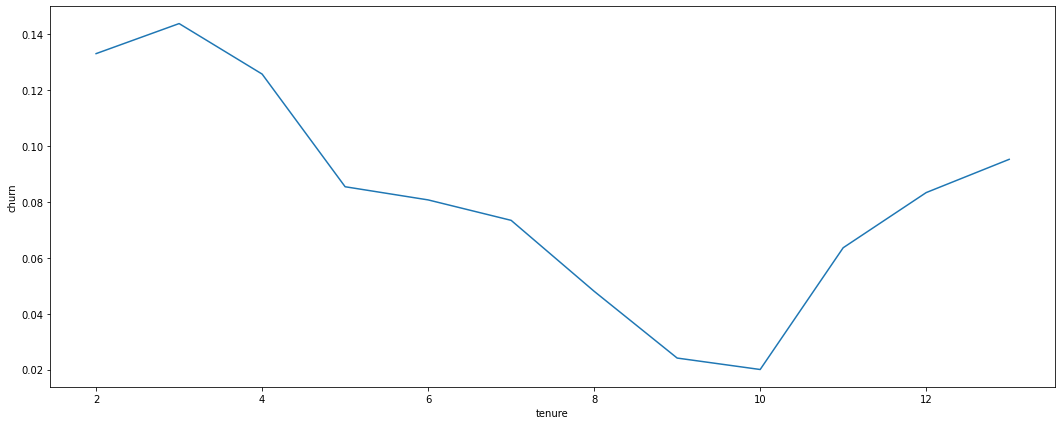

In [16]:
plt.figure(figsize=(18,7))
sns.lineplot(data= df.groupby('tenure').agg({'churn':'mean'}).sort_values(by='churn', ascending=False).reset_index(), x='tenure', y='churn')

Companies who have been clients for less than 4 years are more likely to churn. The churn rate increases after 10 years of subscription.

#### Transform dates into months 

In [17]:
df[['date_activ', 'date_end', 'date_modif_prod','date_renewal']]

,date_activ,date_end,date_modif_prod,date_renewal
0,2013-06-15,2016-06-15,2015-11-01,2015-06-23
1,2009-08-21,2016-08-30,2009-08-21,2015-08-31
2,2010-04-16,2016-04-16,2010-04-16,2015-04-17
3,2010-03-30,2016-03-30,2010-03-30,2015-03-31
4,2010-01-13,2016-03-07,2010-01-13,2015-03-09
...,...,...,...,...
14600,2012-05-24,2016-05-08,2015-05-08,2014-05-26
14601,2012-08-27,2016-08-27,2012-08-27,2015-08-28
14602,2012-02-08,2016-02-07,2012-02-08,2015-02-09
14603,2012-08-30,2016-08-30,2012-08-30,2015-08-31


In [18]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [19]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [20]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head(5)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,2,71,9


#### Transforming boolean data

`has_gas` :- we simply want to transform this column from being categorical to being a binary flag.

In [21]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081887


Customers who buy multiple products from company are loyal towards the company. Churn Rate is comparatively lower.

#### Transforming categorical data

In [22]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [23]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')

#Dropping categories having very less values
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,7,76,7,76,4,1,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,6,68,3,68,8,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,6,69,2,69,9,0,0,0,1,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,6,71,2,71,9,1,0,0,0,0


#### Transforming numerical data

In [24]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


Apply log10 transformation

In [25]:
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [26]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.966450,1.517233,0.137282,0.050488,43.130085
std,0.884545,1.716828,1.769266,0.683612,1.584972,5.108355,0.571489,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.143166,0.084138,44.311378
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

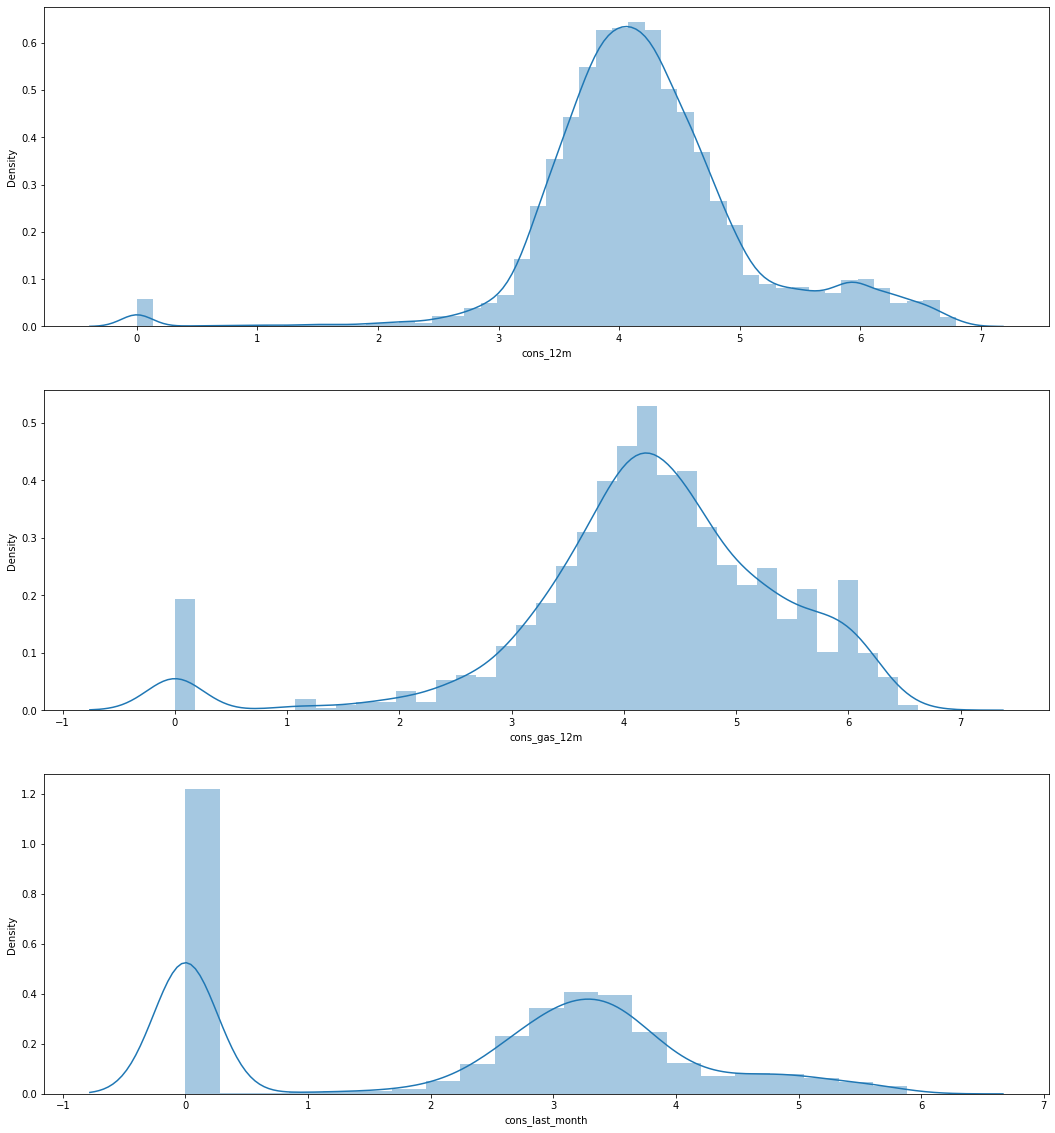

In [27]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

#### Corelations

This is important because it reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [28]:
correlation = df.corr().abs()

/var/folders/jk/45pfmj415lb9l0__2lq4xmr40000gn/T/ipykernel_1262/2751692514.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr().abs()


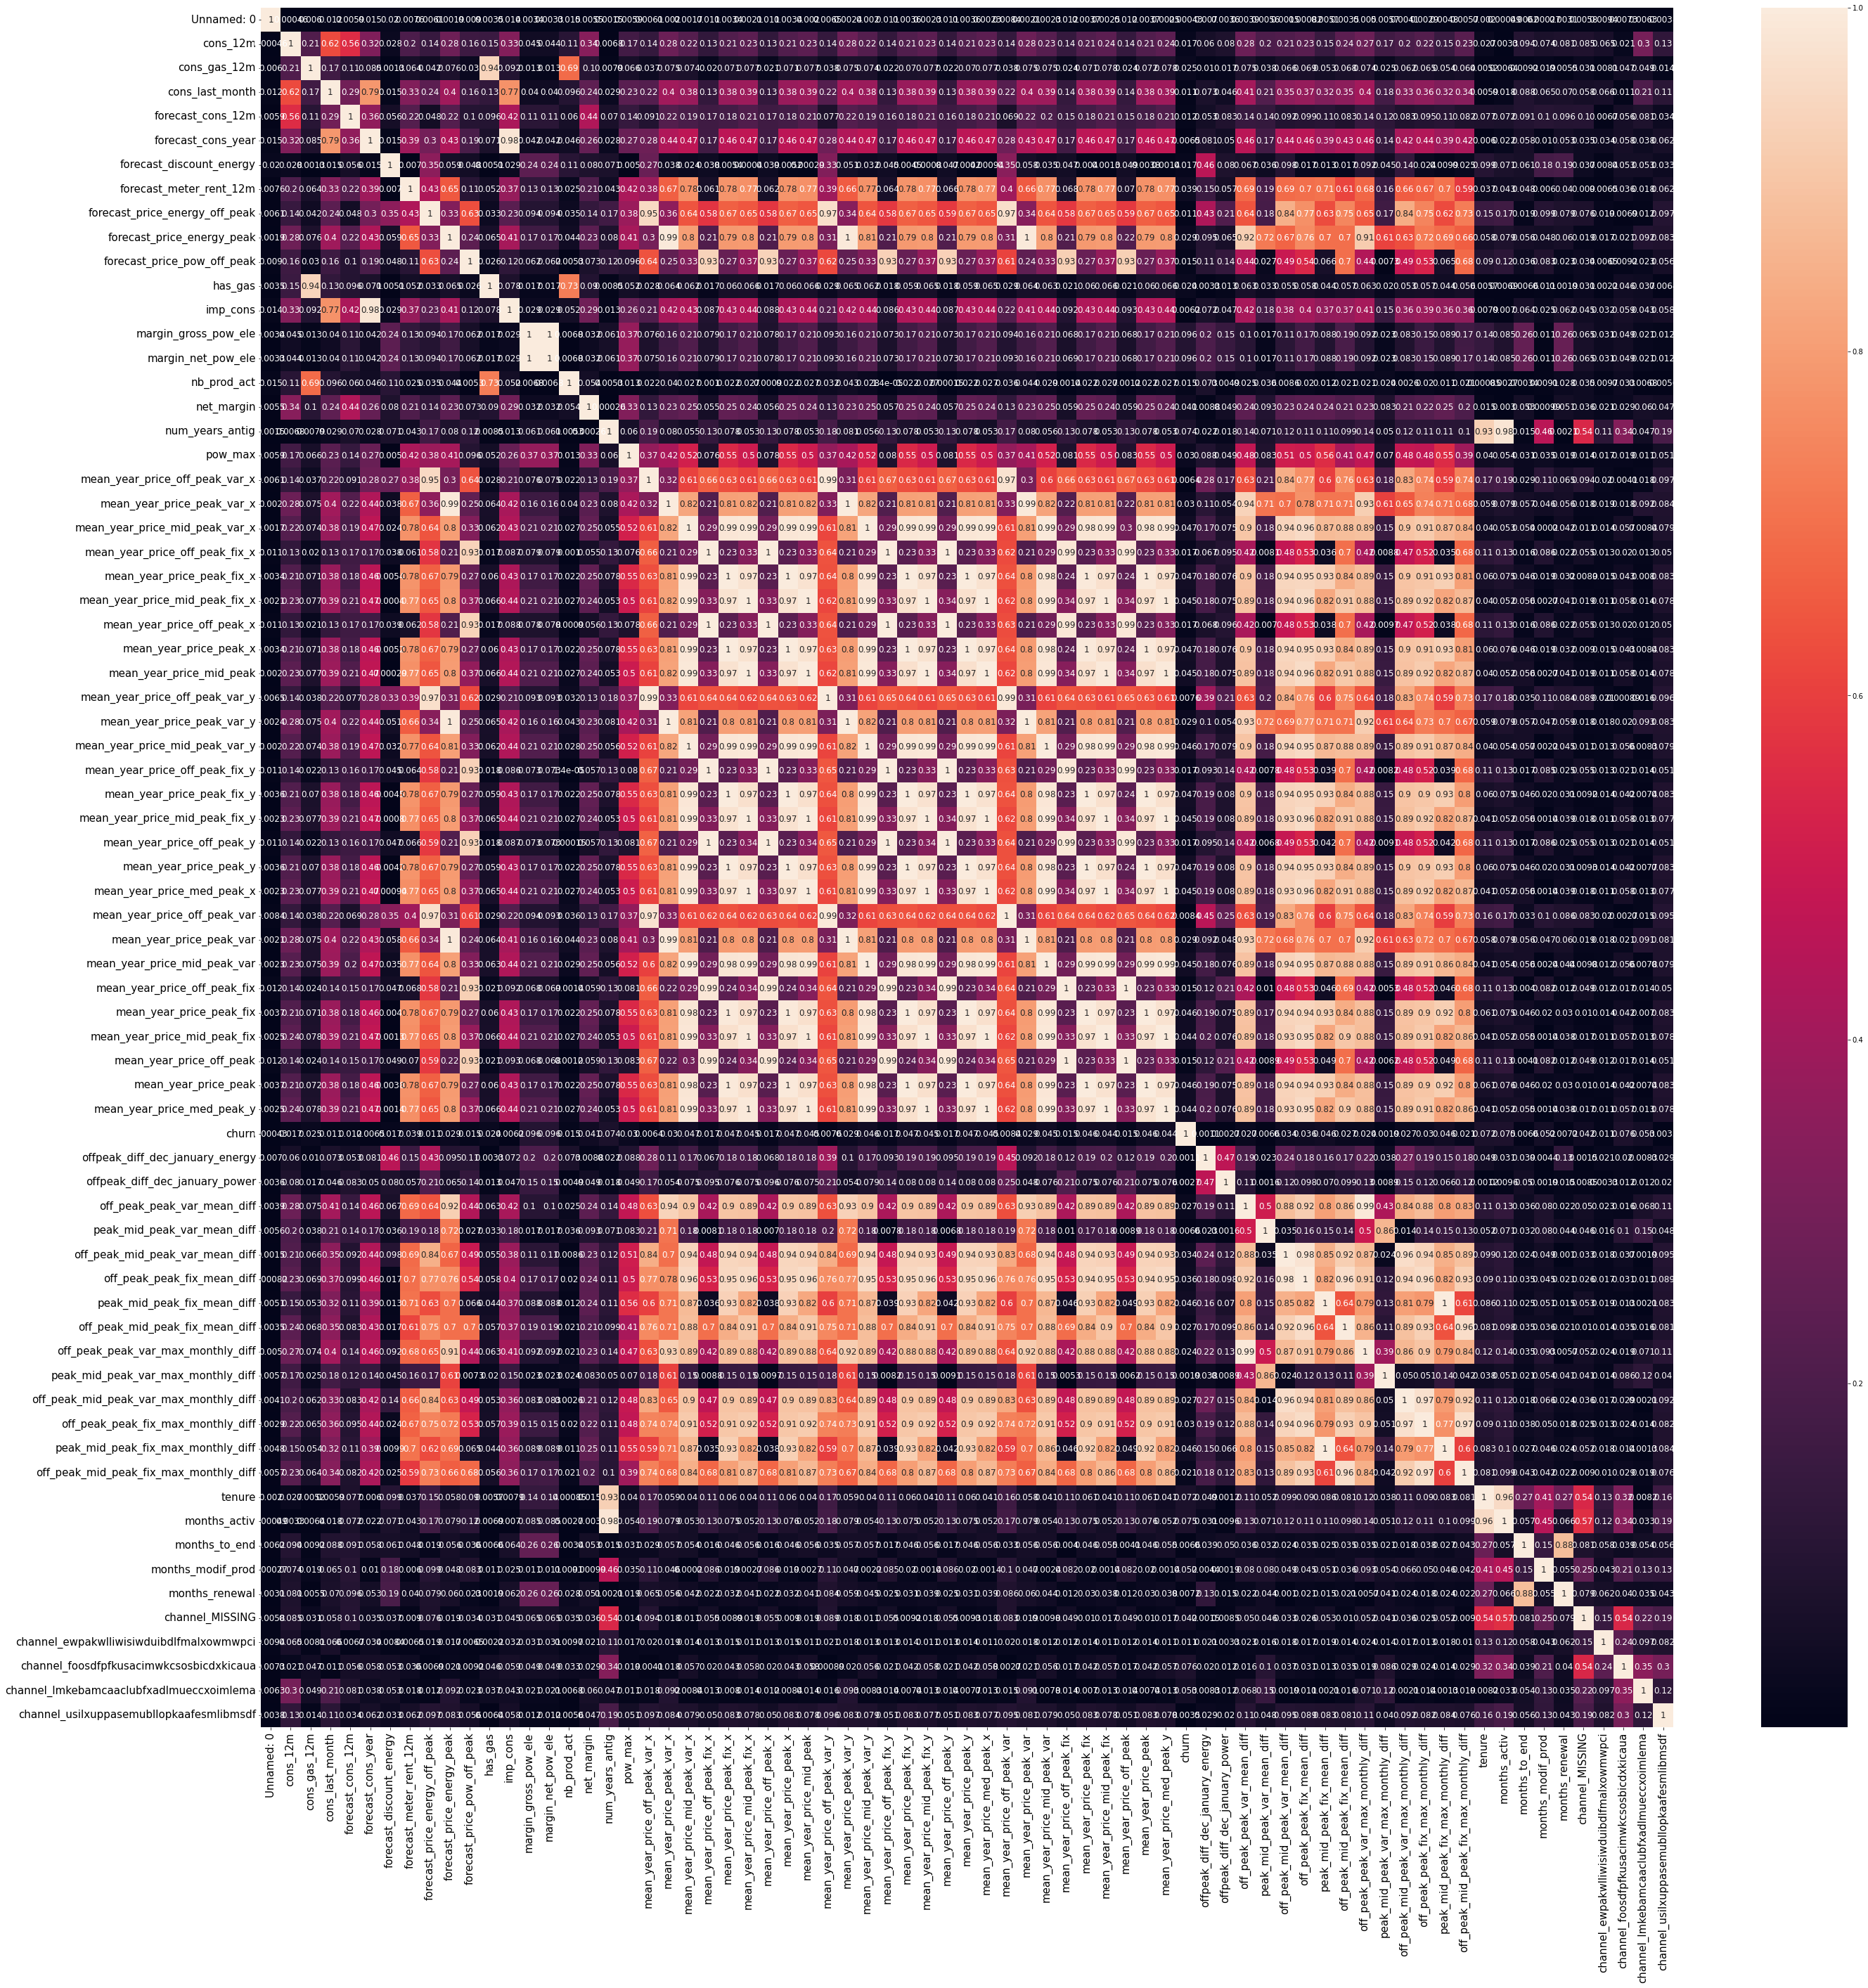

In [29]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation, 
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values, 
    annot=True, 
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()